In [4]:
pip install --upgrade Pillow --user

Note: you may need to restart the kernel to use updated packages.


Pobranie niezbędnych bibliotek

In [1]:
import pandas as pd
import string 
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

#library used to count the frequency of words
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
#nltk.download('wordnet') 
#nltk.download('omw-1.4')

Pobranie tekstów piosenek

In [2]:
df=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/Metallica_songs.csv', sep=';')
#df['Release_date'] = pd.to_datetime(df['Release_date'])
df.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics
192,The Train Kept-A-Rollin’,Tiny Bradshaw,"Tiny Bradshaw,Lois Mann,Howard Kay",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/the-train-kept...,"I caught a train met a dame,She was a hipster ..."
28,The Chase Is Better Than the Catch,Motörhead,"Ian Fraser Kilmister,Eddie Clarke,Phil Taylor",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/the-chase-is-b...,"You know I’m bad the times I’ve had,I’ve got a..."
115,Mama Said,Metallica,"James Hetfield,Lars Ulrich",5:20,Load,Album,11.0,1996-06-04,https://www.metallica.com/songs/mama-said.html,"Mama she has taught me well,Told me when I was..."
51,Dragon,Metallica,"Lou Reed,James Hetfield,Lars Ulrich,Kirk Hamme...",11:10,Lulu,Collaborative,9.0,2011-10-31,https://www.metallica.com/songs/dragon.html,"You don’t actually care,Love for you is no beg..."
166,Seek & Destroy,Metallica,"James Hetfield,Lars Ulrich",6:54,Kill 'Em All,Album,9.0,1983-07-25,https://www.metallica.com/songs/seek-and-destr...,"We’re scanning the scene in the city tonight,W..."


Przygotowanie niezbędnych funkcji

In [3]:
def clean_lyrics(df,column):
    """
    This function cleans the words without importance and fix the format of the  dataframe's column lyrics 

    parameters:
    df = dataframe
    column = name of the column to clean
    """
    df = df
    df['Lyrics'] = df['Lyrics'].str.lower()
    df['Lyrics'] = df['Lyrics'].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
    df['Lyrics'] = df['Lyrics'].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df['Lyrics'] = df['Lyrics'].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+","").str.replace("efil ym fo flah","")
    df['Lyrics'] = df['Lyrics'].str.strip()

    return df

def lyrics_to_words(document):
    """
    This function splits the text of lyrics to single words, removing stopwords and doing the lemmatization to each word

    parameters:
    document: text to split to single words
    """
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

In [4]:
df_cleaned = clean_lyrics(df,'Lyrics')
df = df[df['Lyrics'].notnull()]
df_cleaned.sample(5)

C:\Users\szwac\AppData\Local\Temp\ipykernel_12976\3180326090.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Lyrics'] = df['Lyrics'].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
C:\Users\szwac\AppData\Local\Temp\ipykernel_12976\3180326090.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Lyrics'] = df['Lyrics'].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
C:\Users\szwac\AppData\Local\Temp\ipykernel_12976\3180326090.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Lyrics'] = df['Lyrics'].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
C:\Users\szwac\AppData\Local\Temp\ipykernel_12976\3180326090.py:13

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics
171,Slither,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",5:13,Reload,Album,6.0,1997-11-18,https://www.metallica.com/songs/slither.html,dont go looking for snakes you might find them...
151,Poor Twisted Me,Metallica,"James Hetfield,Lars Ulrich",4:00,Load,Album,9.0,1996-06-04,https://www.metallica.com/songs/poor-twisted-m...,oh poor twisted meoh poor twisted mei feast on...
31,Clampdown,The Clash,"Joe Strummer,Mick Jones",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/clampdown.html,what are we gonna do now taking off his turban...
13,"Atlas, Rise!",Metallica,"James Hetfield,Lars Ulrich",6:28,Hardwired... to Self-Destruct,Album,2.0,2016-11-18,https://www.metallica.com/songs/atlas-rise.html,bitterness and burdencurses rest on theesolita...
69,Funeral for a Friend/Love Lies Bleeding,Elton John,"Elton John,Bernie Taupin",NaN,NaN,NaN,NaN,NaN,https://www.metallica.com/songs/funeral-for-a-...,the roses in the window boxhave tilted to one ...


Ze zbioru utworów usuwam piosenki nie będące autorstwa Metallici.

In [5]:
df_cleaned2 = df_cleaned[df_cleaned['Author_band'] == 'Metallica']
df_cleaned2.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/teksty.csv',index=False)
df_cleaned2.sample(5)

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics
100,Just a Bullet Away,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",7:11,Beyond Magnetic,EP,2.0,2011-12-13,https://www.metallica.com/songs/just-a-bullet-...,all roads they lead to shameall drowning in th...
116,ManUNKind,Metallica,"James Hetfield,Lars Ulrich,Robert Trujillo",6:55,Hardwired... to Self-Destruct,Album,8.0,2016-11-18,https://www.metallica.com/songs/manunkind.html,chaosawaiting for adams returnmadnesssmiling a...
5,All Nightmare Long,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",8:01,Death Magnetic,Album,5.0,2008-09-12,https://www.metallica.com/songs/all-nightmare-...,luck runs out crawl from the wreckage one more...
164,Sad But True,Metallica,"James Hetfield,Lars Ulrich",5:24,Metallica,Album,2.0,1991-08-12,https://www.metallica.com/songs/sad-but-true.html,heyim your lifeim the one who takes you there ...
45,Devil’s Dance,Metallica,"James Hetfield,Lars Ulrich",5:19,Reload,Album,3.0,1997-11-18,https://www.metallica.com/songs/devils-dance.html,i feel you toofeel those things you doin your ...


In [6]:
def unique(list1):
   # intilize a null list
     unique_list = []
   # traverse for all elements
     for x in list1:
         # check if exists in unique_list or not
         if x not in unique_list:
              unique_list.append(x)
     return unique_list

In [7]:
#Stores unique words of each lyrics song into a new column called words
#list used to store the words
words = []
#iterate trought each lyric and split unique words appending the result into the words list
df_cleaned2 = df_cleaned2.reset_index(drop=True)
for word in df_cleaned2['Lyrics'].tolist():
    words.append(unique(lyrics_to_words(word).split()))
#create the new column with the information of words lists
df_cleaned2['words'] = words
df_cleaned2.head()

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics,words
0,2 x 4,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",5:28,Load,Album,2.0,1996-06-04,https://www.metallica.com/songs/2x4.html,im gonna make you shake you take youim gonna b...,"[im, gonna, make, shake, take, youim, one, bre..."
1,72 Seasons,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",7:39,72 Seasons,Album,1.0,2023-04-14,https://www.metallica.com/songs/72-seasons.html,feeding on the wrath of manshot downtraumatict...,"[feeding, wrath, manshot, downtraumatictime, h..."
2,Ain’t My Bitch,Metallica,"James Hetfield,Lars Ulrich",5:04,Load,Album,1.0,1996-06-04,https://www.metallica.com/songs/aint-my-bitch....,outta my wayoutta my dayout of your mind and i...,"[outta, wayoutta, dayout, mind, mine, oneinto,..."
3,All Nightmare Long,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",8:01,Death Magnetic,Album,5.0,2008-09-12,https://www.metallica.com/songs/all-nightmare-...,luck runs out crawl from the wreckage one more...,"[luck, run, crawl, wreckage, one, timehorrific..."
4,All Within My Hands,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Bob Rock",8:48,St. Anger,Album,11.0,2003-06-05,https://www.metallica.com/songs/all-within-my-...,all within my handssqueeze it in crush it down...,"[within, handssqueeze, crush, downall, handsho..."


In [8]:
df_cleaned2['frequency'] = 0
df_cleaned2['frequency'] = df_cleaned2['frequency'].astype(int)
df = df_cleaned2
#Create a new dataframe of all the  words used in lyrics and its decades 

#list used to store the information
set_words = []
set_frequency = []

#Iterate trought each word and decade and stores them into the new lists
for i in df.index:
    for word in df['words'].iloc[i]:
        set_words.append(word)
        set_frequency.append(df['frequency'].iloc[i])

#create the new data frame  with the information of words and decade lists 
words_df = pd.DataFrame({'words':set_words,'frequency':set_frequency})

In [10]:
df.head()

,Song,Author_band,Songwriters,Duration,Album,Album_type,No_on_album,Release_date,Link,Lyrics,words,frequency
0,2 x 4,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",5:28,Load,Album,2.0,1996-06-04,https://www.metallica.com/songs/2x4.html,im gonna make you shake you take youim gonna b...,"[im, gonna, make, shake, take, youim, one, bre...",0
1,72 Seasons,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett",7:39,72 Seasons,Album,1.0,2023-04-14,https://www.metallica.com/songs/72-seasons.html,feeding on the wrath of manshot downtraumatict...,"[feeding, wrath, manshot, downtraumatictime, h...",0
2,Ain’t My Bitch,Metallica,"James Hetfield,Lars Ulrich",5:04,Load,Album,1.0,1996-06-04,https://www.metallica.com/songs/aint-my-bitch....,outta my wayoutta my dayout of your mind and i...,"[outta, wayoutta, dayout, mind, mine, oneinto,...",0
3,All Nightmare Long,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Robert...",8:01,Death Magnetic,Album,5.0,2008-09-12,https://www.metallica.com/songs/all-nightmare-...,luck runs out crawl from the wreckage one more...,"[luck, run, crawl, wreckage, one, timehorrific...",0
4,All Within My Hands,Metallica,"James Hetfield,Lars Ulrich,Kirk Hammett,Bob Rock",8:48,St. Anger,Album,11.0,2003-06-05,https://www.metallica.com/songs/all-within-my-...,all within my handssqueeze it in crush it down...,"[within, handssqueeze, crush, downall, handsho...",0


In [9]:
#Defined  your own Stopwords in case the clean data function does not remove all of them
stop_words = ['45','verse','im','get','1000','58','60','80','youre','youve',
               'guitar','solo','instrumental','intro','pre',"3","yo","yeah"]

# count the frequency of each word that don't have on the stop_words lists          
cv = CountVectorizer(stop_words=stop_words)

#Create a dataframe called data_cv to store the the number of times the word was used in  a lyric based their decades
text_cv = cv.fit_transform(words_df['words'].iloc[:])
data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names_out())
data_cv['frequency'] = words_df['frequency']

#created a dataframe that Sums the ocurrence frequency of each word and group the result by decade
vect_words = data_cv.groupby('frequency').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns ={'index':'words'})
vect_words = vect_words.rename_axis(columns='')

#Save the data into a csv file
vect_words.to_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv',index=False)

#change the order of columns to order from the oldest to actual decade
#vect_words = vect_words[['words','80s','90s','00s','10s']]

In [10]:
words=pd.read_csv('C:/Users/szwac/Documents/Data science/IV semestr/Eksploracja danych tekstowych - lab/projekt/words.csv', sep=',')


In [11]:
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5203 entries, 0 to 5202
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   words   5203 non-null   object
 1   0       5203 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.4+ KB


In [12]:
words.rename(columns={'0': 'frequency'}, inplace=True)

# Sprawdzenie zmian
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5203 entries, 0 to 5202
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   words      5203 non-null   object
 1   frequency  5203 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.4+ KB


In [13]:
words_sorted = words.sort_values(by='frequency', ascending=False)
words_sorted.head(20)

,words,frequency
2501,life,47
3012,never,45
4393,take,42
3824,see,41
1198,dont,39
1518,feel,39
3135,one,38
786,come,37
4555,time,34
2393,know,30


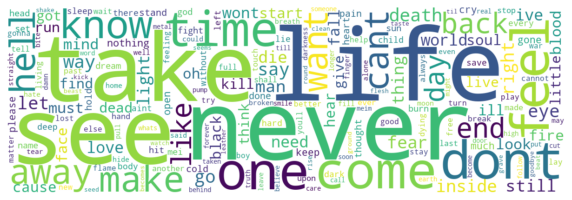

In [18]:
#tworzy słownik z df
word_freq = dict(zip(words_sorted['words'], words_sorted['frequency']))

font_path = 'C:/Windows/Fonts/arial.ttf'

# Generowanie chmury słów
wordcloud = WordCloud(width=1200, height=400, background_color='white').generate_from_frequencies(word_freq)

# Wyświetlenie chmury słów
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
def words_stats(df,main_df):
    unique_words = []
    total_words = []
    total_news = []
    years = []
    for value in df.columns[1:]:
         unique_words.append(np.count_nonzero(df[value]))
         total_words.append(sum(df[value]))
         years.append(str(value))
         total_news.append(main_df['frequency'][main_df['frequency']==value].count())
    
    data = pd.DataFrame({'unique words':unique_words,'total words':total_words,'total songs':total_news})
    data['words per songs'] = round(data['total words'] / data['total songs'],0)
    data['words per songs'] = data['words per songs'].astype('int')
    return data


In [17]:
words_stats(vect_words,df)

,unique words,total words,total songs,words per songs
0,5203,9275,147,63
